In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk import bigrams
from collections import Counter
import networkx as nx

In [2]:
nltk.download('stopwords')
sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alici\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
reviews = pd.read_json("../../../project/IMDB_reviews.json", lines=True)
movies = pd.read_json("../../../project/IMDB_movie_details.json", lines=True)

df = pd.merge(reviews, movies, on="movie_id", how="left")
df['rating_x'] = pd.to_numeric(df['rating_x'], errors='coerce')
df

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ..."
573909,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ..."
573910,20 July 1999,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ..."
573911,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ..."


# Updated Pre-clean EDA

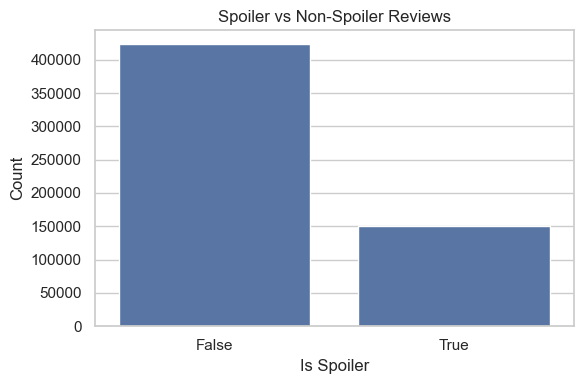

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_spoiler')
plt.title("Spoiler vs Non-Spoiler Reviews")
plt.xlabel("Is Spoiler")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

C:\Users\alici\AppData\Local\Temp\ipykernel_26100\1827366178.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportion_by_rating = (df.groupby('rating_bin_y')['is_spoiler']


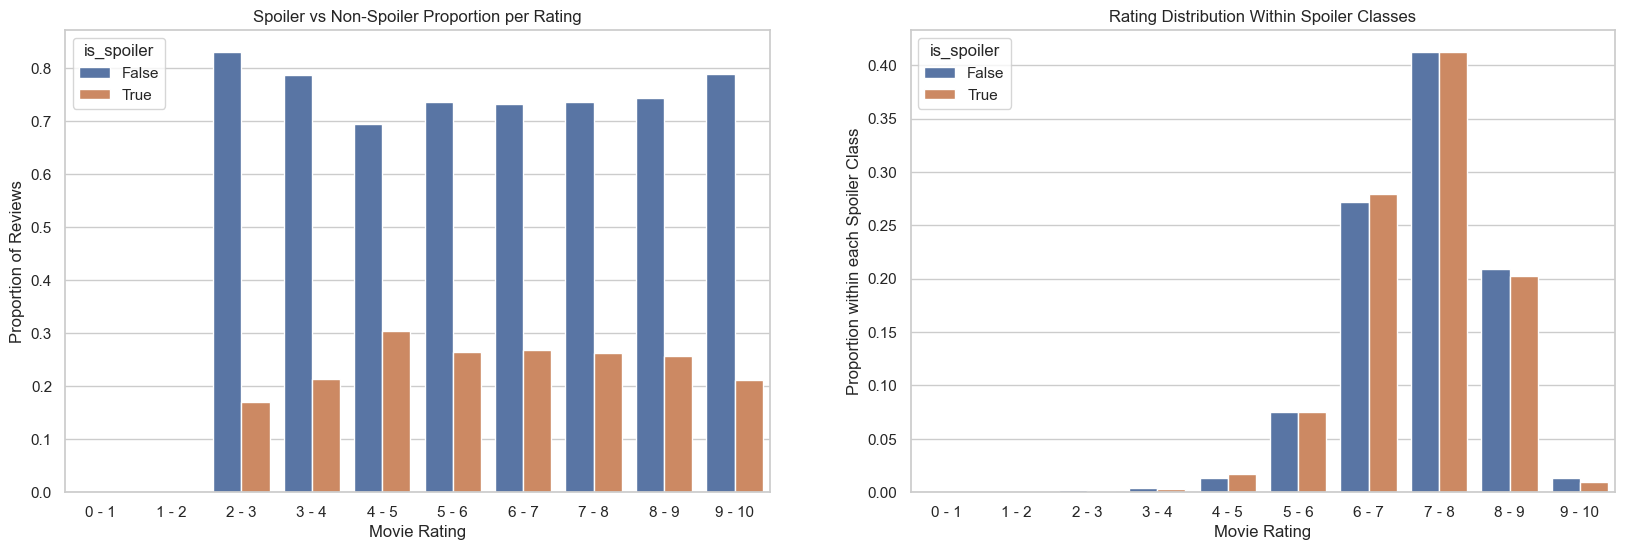

In [5]:
df['rating_y'] = pd.to_numeric(df['rating_y'], errors='coerce')
df['rating_bin_y'] = pd.cut(df['rating_y'], bins=[0,1,2,3,4,5,6,7,8,9,10], 
                            labels=['0 - 1','1 - 2','2 - 3','3 - 4','4 - 5','5 - 6','6 - 7','7 - 8','8 - 9','9 - 10'])
proportion_by_rating = (df.groupby('rating_bin_y')['is_spoiler']
                 .value_counts(normalize=True)
                 .rename('proportion')
                 .reset_index())
proportion_by_spoiler = (df.groupby('is_spoiler')['rating_bin_y']
                 .value_counts(normalize=True)
                 .rename('proportion')
                 .reset_index())
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

sns.barplot(ax=axes[0], x='rating_bin_y', y='proportion', hue='is_spoiler', data=proportion_by_rating)
axes[0].set_title("Spoiler vs Non-Spoiler Proportion per Rating")
axes[0].set_xlabel("Movie Rating")
axes[0].set_ylabel("Proportion of Reviews")
axes[0].legend(title='is_spoiler')

sns.barplot(ax=axes[1], x='rating_bin_y', y='proportion', hue='is_spoiler', data=proportion_by_spoiler)
axes[1].set_title("Rating Distribution Within Spoiler Classes")
axes[1].set_xlabel("Movie Rating")
axes[1].set_ylabel("Proportion within each Spoiler Class")
axes[1].legend(title='is_spoiler', loc = 'upper left')

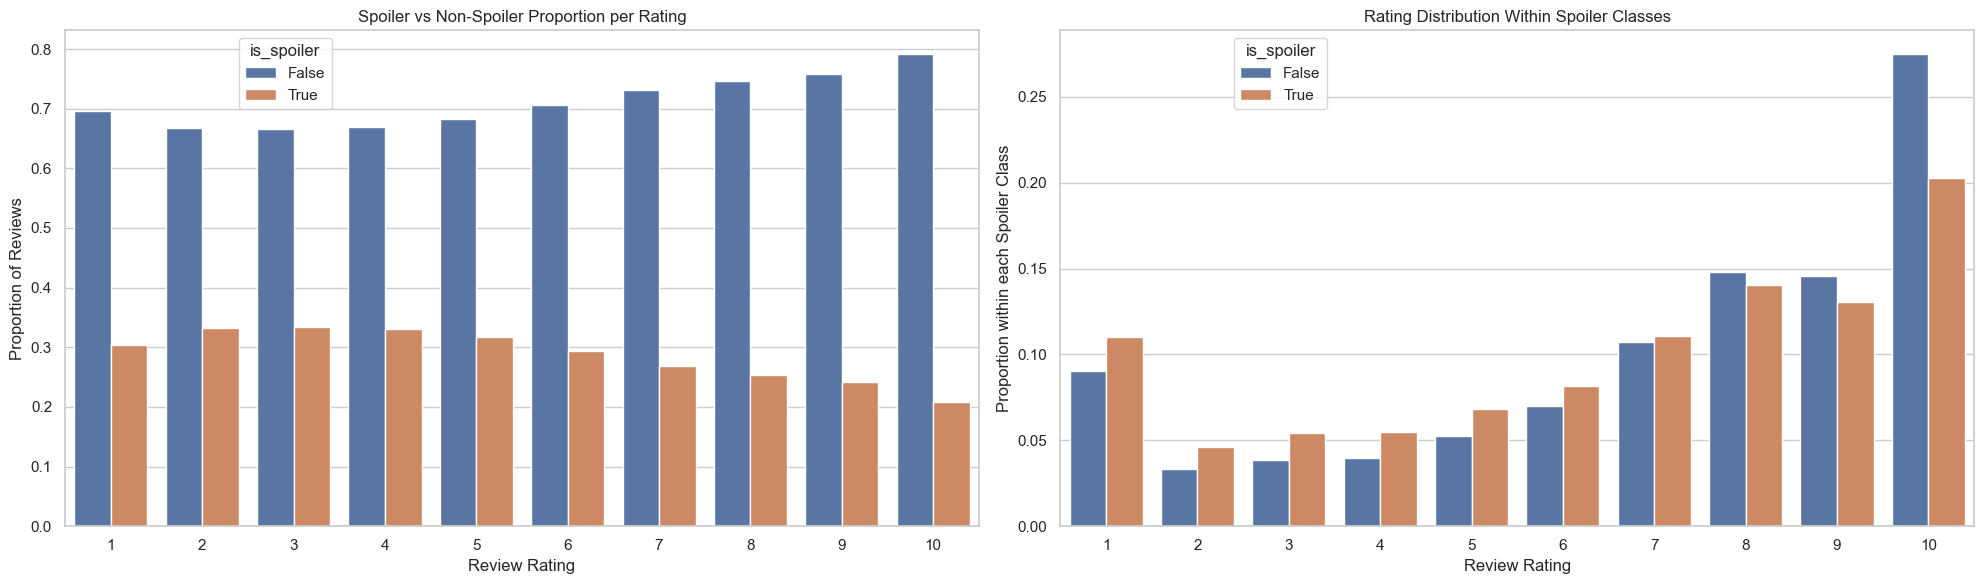

In [ ]:
df['rating_x'] = pd.to_numeric(df['rating_x'], errors='coerce')
proportion_by_rating = (
    df.groupby('rating_x')['is_spoiler']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index())

proportion_by_spoiler = (
    df.groupby('is_spoiler')['rating_x']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index())
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

sns.barplot(ax=axes[0], x='rating_x', y='proportion', hue='is_spoiler', data=proportion_by_rating)
axes[0].set_title("Spoiler vs Non-Spoiler Proportion per Rating")
axes[0].set_xlabel("Review Rating")
axes[0].set_ylabel("Proportion of Reviews")
axes[0].legend(title='is_spoiler', bbox_to_anchor=(0.3, 1))

sns.barplot(ax=axes[1], x='rating_x', y='proportion', hue='is_spoiler', data=proportion_by_spoiler)
axes[1].set_title("Rating Distribution Within Spoiler Classes")
axes[1].set_xlabel("Review Rating")
axes[1].set_ylabel("Proportion within each Spoiler Class")
axes[1].legend(title='is_spoiler', bbox_to_anchor=(0.3, 1))

plt.tight_layout()
plt.show()

# Version 1 (Old version! Ignore)

## Bar Graph

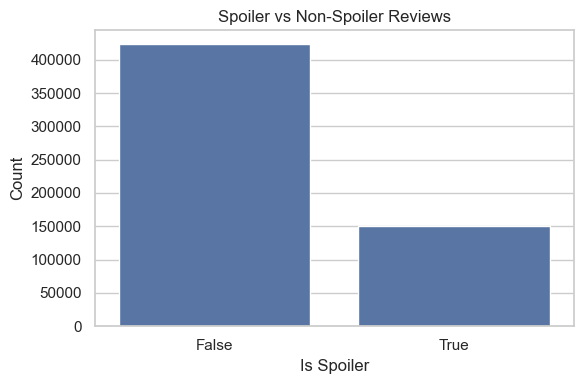

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_spoiler')
plt.title("Spoiler vs Non-Spoiler Reviews")
plt.xlabel("Is Spoiler")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

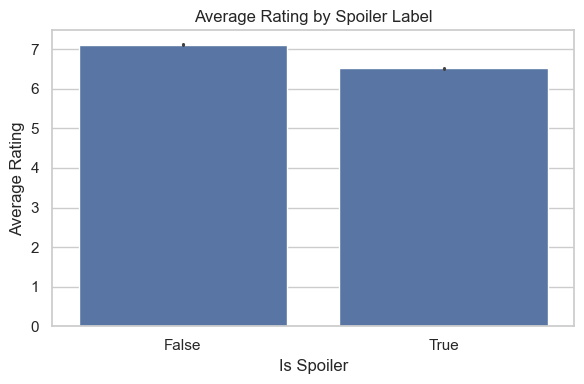

In [ ]:
# 2. Average Rating by Spoiler Label
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='is_spoiler', y='rating_x')
plt.title("Average Rating by Spoiler Label")
plt.xlabel("Is Spoiler")
plt.ylabel("Average Rating")
plt.tight_layout

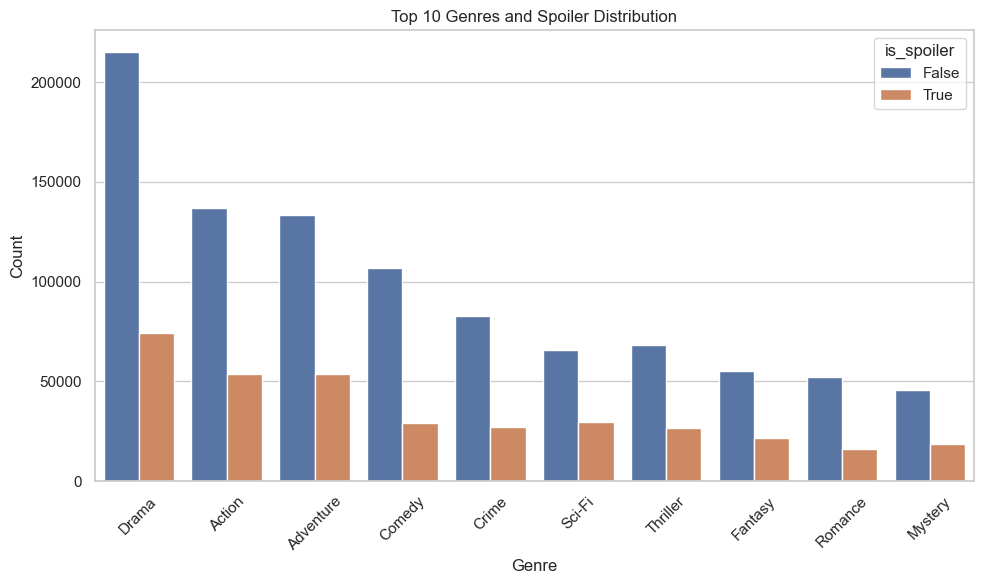

In [ ]:
# 3. Top 10 Genres by Spoiler Label
df_exploded = df.explode("genre")
df_exploded = df_exploded.dropna(subset=["genre"])
top_genres = df_exploded['genre'].value_counts().nlargest(10).index.tolist()
df_top_genres = df_exploded[df_exploded['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_genres, x='genre', hue='is_spoiler', order=top_genres)
plt.title("Top 10 Genres and Spoiler Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

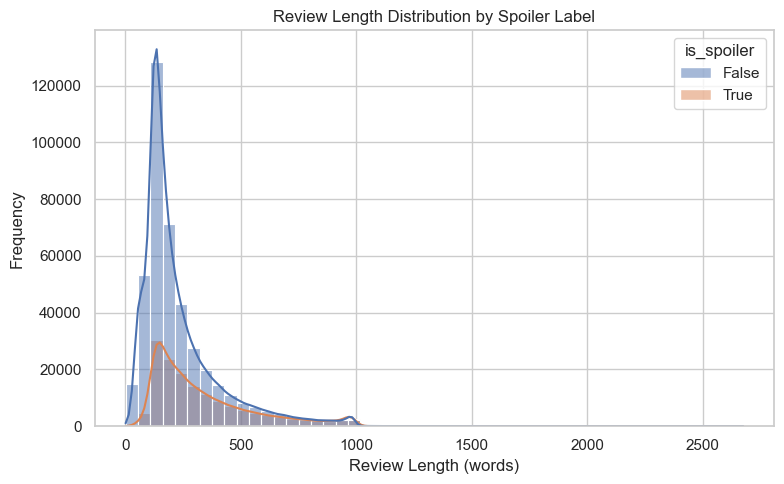

In [ ]:
# 4. Review Length Distribution
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='review_length', hue='is_spoiler', bins=50, kde=True)
plt.title("Review Length Distribution by Spoiler Label")
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

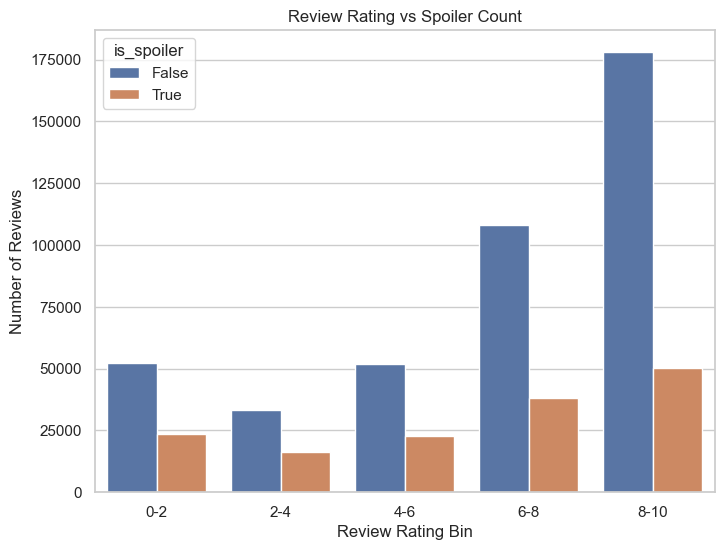

In [ ]:
df['rating_x'] = pd.to_numeric(df['rating_x'], errors='coerce')
df['rating_bin'] = pd.cut(df['rating_x'], bins=[0, 2, 4, 6, 8, 10], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating_bin', hue='is_spoiler')
plt.title("Review Rating vs Spoiler Count")
plt.xlabel("Review Rating Bin")
plt.ylabel("Number of Reviews")
plt.show()

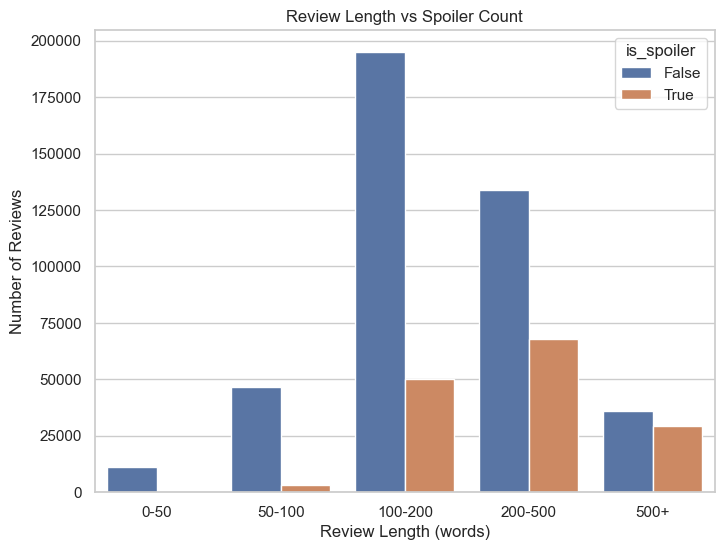

In [ ]:
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

df['length_bin'] = pd.cut(df['review_length'], bins=[0, 50, 100, 200, 500, 1000], 
                          labels=["0-50", "50-100", "100-200", "200-500", "500+"])

# Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='length_bin', hue='is_spoiler')
plt.title("Review Length vs Spoiler Count")
plt.xlabel("Review Length (words)")
plt.ylabel("Number of Reviews")
plt.show()

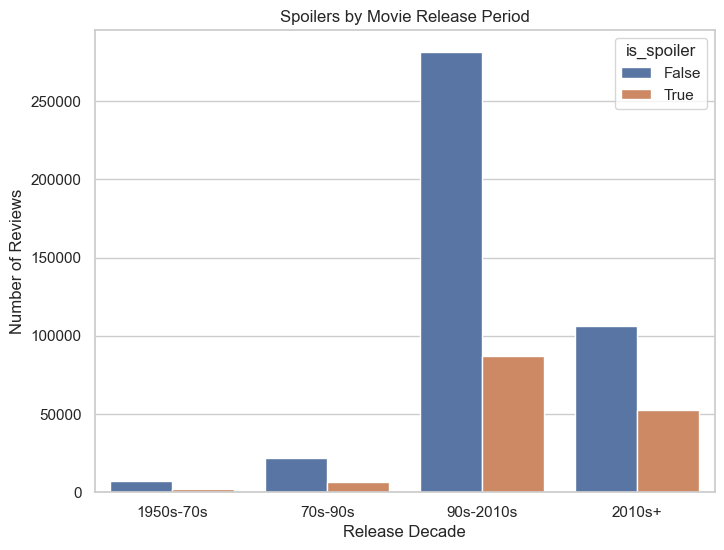

In [ ]:
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

df['release_decade'] = pd.cut(df['release_year'], bins=[1950, 1970, 1990, 2010, 2030],
                              labels=["1950s-70s", "70s-90s", "90s-2010s", "2010s+"])

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='release_decade', hue='is_spoiler')
plt.title("Spoilers by Movie Release Period")
plt.xlabel("Release Decade")
plt.ylabel("Number of Reviews")
plt.show()

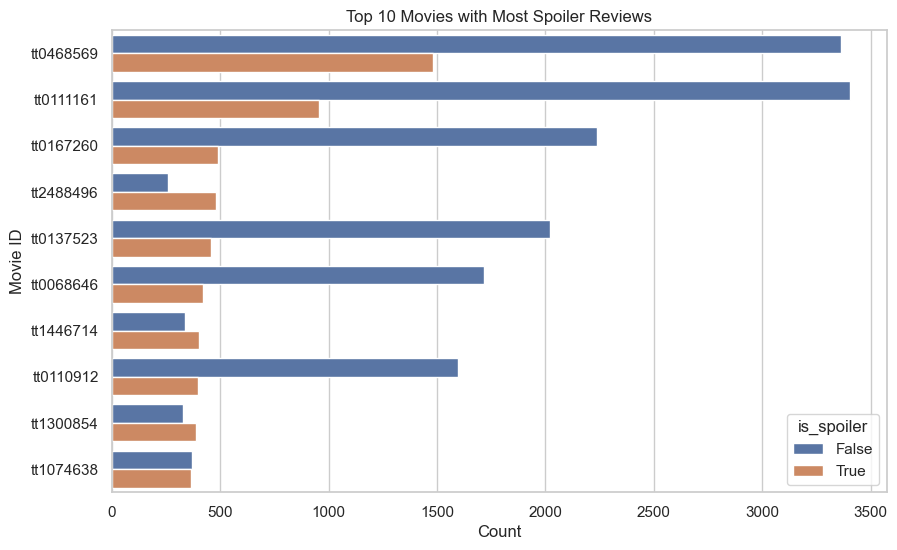

In [ ]:
top_movies = df[df['is_spoiler'] == True]['movie_id'].value_counts().nlargest(10).index
df_top_spoiler_movies = df[df['movie_id'].isin(top_movies)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_spoiler_movies, y='movie_id', hue='is_spoiler', order=top_movies)
plt.title("Top 10 Movies with Most Spoiler Reviews")
plt.xlabel("Count")
plt.ylabel("Movie ID")
plt.show()

## Bigram Network

In [ ]:
def get_top_bigrams(text_series, n=50):
    stop_words = set(stopwords.words('english'))
    bigram_counter = Counter()

    for text in text_series:
        words = [w.lower() for w in re.findall(r'\b\w+\b', text)]
        words = [w for w in words if w not in stop_words]
        bigram_counter.update(bigrams(words))

    return bigram_counter.most_common(n)

In [ ]:
def plot_bigram_network(top_bigrams, title):
    G = nx.Graph()
    for ((w1, w2), count) in top_bigrams:
        G.add_edge(w1, w2, weight=count)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    edges = G.edges(data=True)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=[d['weight'] * 0.2 for (u, v, d) in edges], alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

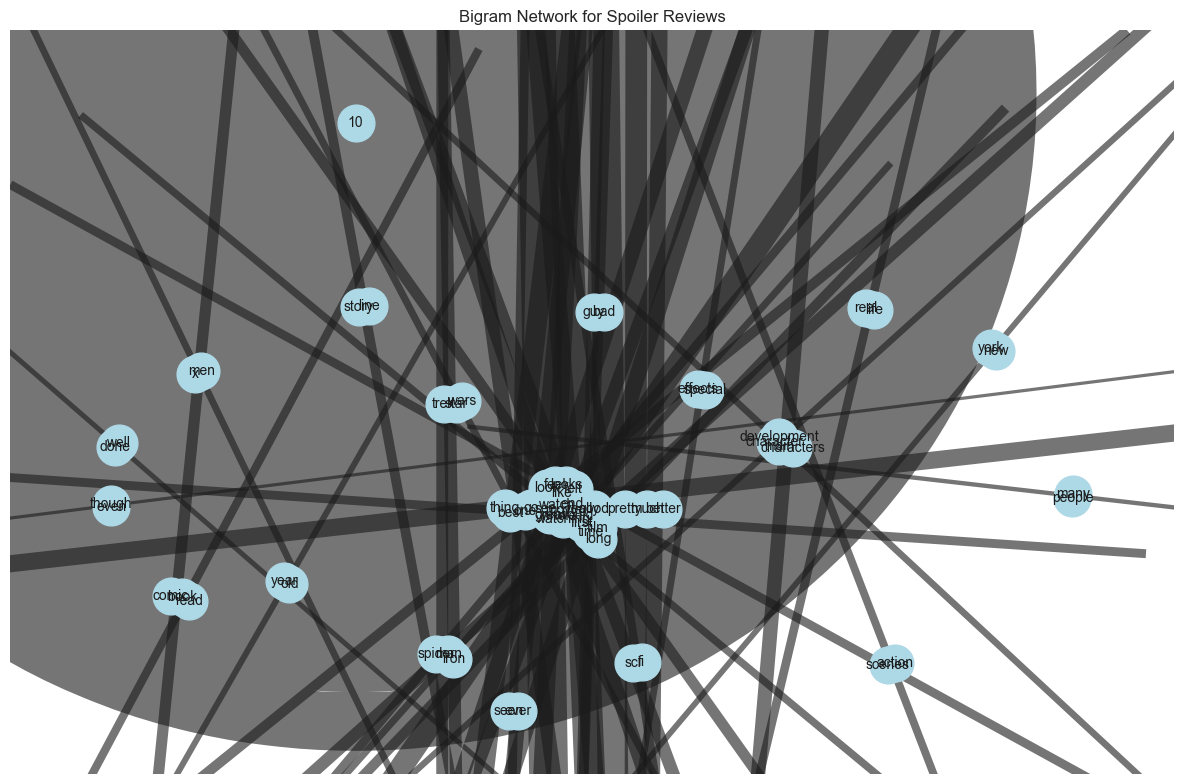

In [ ]:
#top_bigrams_spoiler = get_top_bigrams(df[df['is_spoiler'] == True]['review_text'])
#plot_bigram_network(top_bigrams_spoiler, "Bigram Network for Spoiler Reviews")

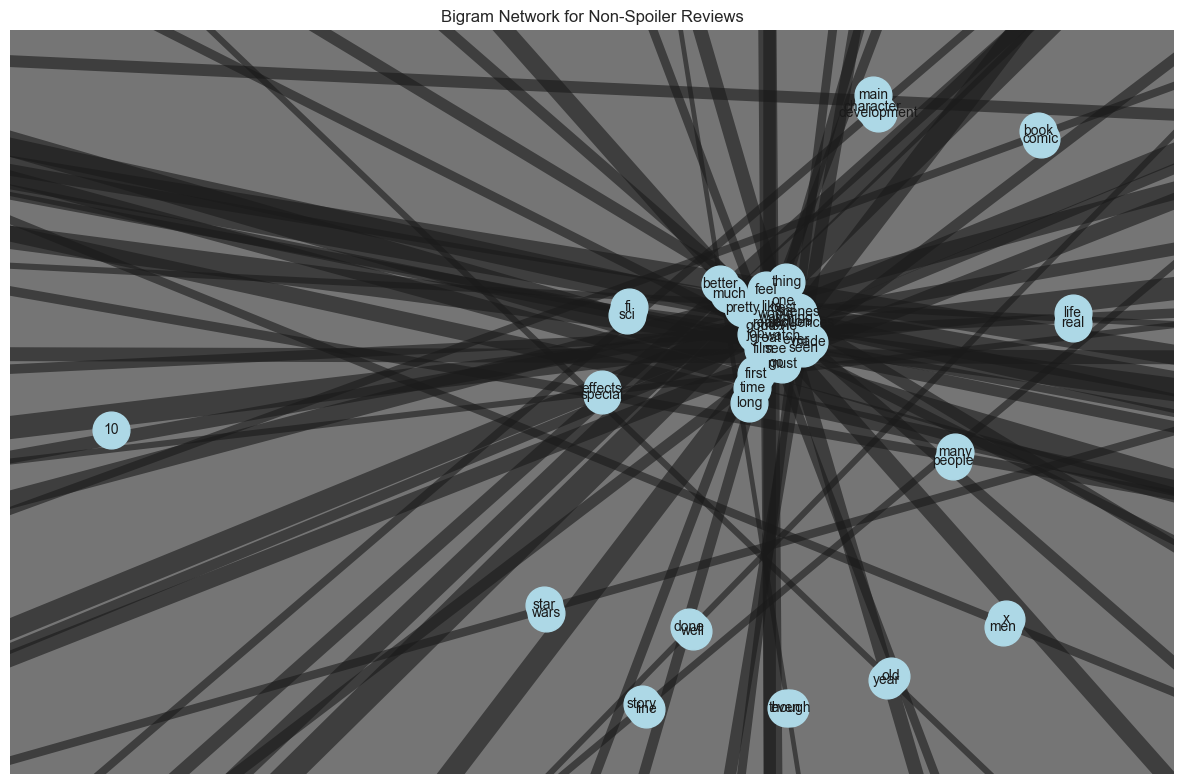

In [ ]:
# Non-spoiler review bigrams
#top_bigrams_non_spoiler = get_top_bigrams(df[df['is_spoiler'] == False]['review_text'])
#plot_bigram_network(top_bigrams_non_spoiler, "Bigram Network for Non-Spoiler Reviews")

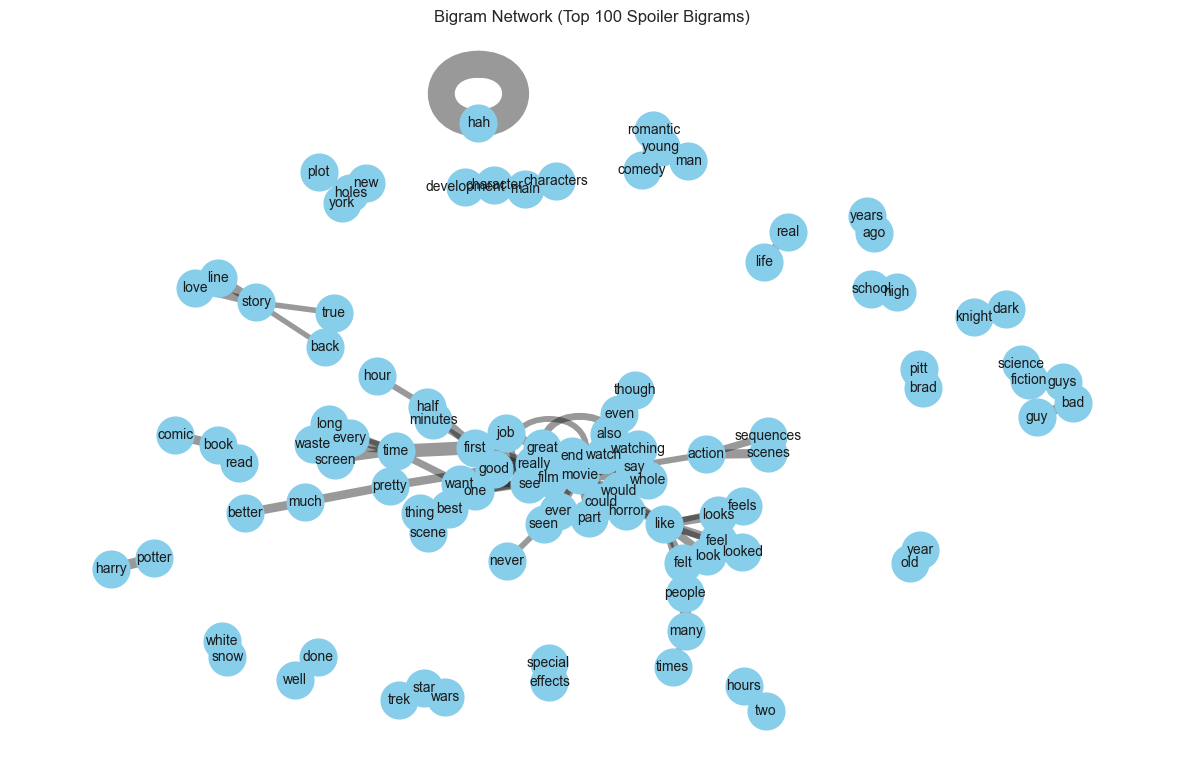

In [ ]:
def get_top_bigrams(text_series, min_freq=5):
    stop_words = set(stopwords.words('english'))
    bigram_counter = Counter()

    for text in text_series:
        words = [w.lower() for w in re.findall(r'\b\w+\b', text)]
        words = [w for w in words if w not in stop_words and len(w) > 2]
        bigram_counter.update(bigrams(words))

    # Filter out rare bigrams
    return [(pair, freq) for pair, freq in bigram_counter.items() if freq >= min_freq]

def plot_bigram_network(top_bigrams, title="Bigram Network"):
    G = nx.Graph()
    
    for (w1, w2), weight in top_bigrams:
        G.add_edge(w1, w2, weight=weight)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    weights = [G[u][v]['weight'] for u, v in G.edges()]
    weights_scaled = [w * 0.2 for w in weights]  # scale edge thickness

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=weights_scaled, alpha=0.4, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 🔍 Example usage:
sample_texts = df[df['is_spoiler'] == True]['review_text'].sample(1000, random_state=1)
spoiler_bigrams = get_top_bigrams(sample_texts, min_freq=10)
top_100_bigrams = sorted(spoiler_bigrams, key=lambda x: x[1], reverse=True)[:100]
#plot_bigram_network(top_100_bigrams, title="Bigram Network (Top 100 Spoiler Bigrams)")
